<a href="https://colab.research.google.com/github/HarshiniR4/Fall-2023-NYU-AI-hr2547/blob/main/Ass_2_part_1_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression Model + CNN Model + Optuna Hyperparameter Tuning - MNIST Dataset**
# Harshini Raju

**NOTE**: Due to lack of GPU and Google Colab's limited resources my training has been constarined to a lower number than expected and/or required.


In [ ]:
%matplotlib inline

from keras.models import Sequential
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Flatten, MaxPooling2D
from keras.layers import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import Callback

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
import tensorflow as tf
from keras.utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.13.1 backend: tensorflow


<ipython-input-1-1ecab18b18b2>:29: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(__version__) >= LV("2.0.0"))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Pre-processing the dataset

Load the data into train and test datasets, shape them appropriately for the mdoel to train and produce optimal solutions

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = to_categorical(y_train, nb_classes).astype('float32')
Y_test = to_categorical(y_test, nb_classes).astype('float32')

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape, X_train.dtype)
print('y_train:', y_train.shape, y_train.dtype)
print('Y_train:', Y_train.shape, Y_train.dtype)

11490434/11490434 [==============================] - 0s 0us/step

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
Y_train: (60000, 10) float32


In [ ]:
%%time
# x_train = X_train.reshape(X_train.shape[0], 1)
nsamples, nx, ny = X_train.shape
x_train = X_train.reshape((nsamples,nx*ny))
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)
CPU times: user 1.99 ms, sys: 15 µs, total: 2.01 ms
Wall time: 1.89 ms


# **Implement the model- Logistic Regression**

In [ ]:
epochs = 170

Implementing a custom Callback function that will help me enable a recursive learnign rate value that follows the formula of

    learning_rate = previous_learning_rate/square_root(n)

where n is the number of the current epoch.

In [ ]:
class LRScheduler(Callback):
    def __init__(self, initial_lr=0.001):
        super(LRScheduler, self).__init__()
        self.initial_lr = initial_lr

    def lr_schedule(self, epoch):
        return self.initial_lr / np.sqrt(epoch + 1)

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = self.lr_schedule(epoch)
        self.model.optimizer.lr = new_lr
        print(f"Epoch {epoch + 1}: Learning rate set to {new_lr:.6f}")

In [ ]:
# Flatten the images for logistic regression
x_train = X_train.reshape(-1, 784)
x_test = X_test.reshape(-1, 784)

In [ ]:
print('X_train:', X_train.shape, X_train.dtype)
print('y_train:', y_train.shape, y_train.dtype)
print('Y_train:', Y_train.shape, Y_train.dtype)

X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
Y_train: (60000, 10) float32


**Logistic Regression with Adam**

In [ ]:
# Build the neural network model for Logistic Regression
model = Sequential()
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', input_shape=(784,)))

In [ ]:
optimizer = Adam(learning_rate=0.001) # Utilising the Adam optimizer to train the data
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
lr_scheduler = LRScheduler(initial_lr=0.001)
lr_history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[lr_scheduler])


score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1: Learning rate set to 0.001000
Epoch 1/170
375/375 [==============================] - 1s 4ms/step - loss: -3008.2534 - accuracy: 0.1140 - val_loss: -3055.6790 - val_accuracy: 0.1060
Epoch 2: Learning rate set to 0.000707
Epoch 2/170
375/375 [==============================] - 1s 4ms/step - loss: -3121.0657 - accuracy: 0.1140 - val_loss: -3145.5730 - val_accuracy: 0.1060
Epoch 3: Learning rate set to 0.000577
Epoch 3/170
375/375 [==============================] - 1s 4ms/step - loss: -3204.4250 - accuracy: 0.1140 - val_loss: -3218.9021 - val_accuracy: 0.1060
Epoch 4: Learning rate set to 0.000500
Epoch 4/170
375/375 [==============================] - 1s 4ms/step - loss: -3272.0286 - accuracy: 0.1140 - val_loss: -3282.4324 - val_accuracy: 0.1060
Epoch 5: Learning rate set to 0.000447
Epoch 5/170
375/375 [==============================] - 1s 3ms/step - loss: -3332.3057 - accuracy: 0.1140 - val_loss: -3339.2881 - val_accuracy: 0.1060
Epoch 6: Learning rate set to 0.000408
Epoch 6/170

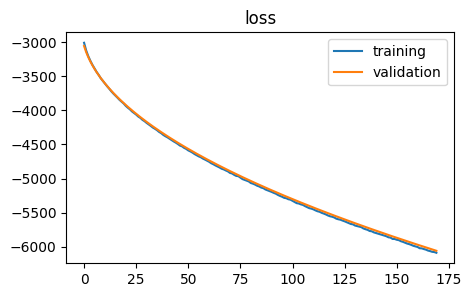

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(lr_history.epoch,lr_history.history['loss'], label='training')
plt.plot(lr_history.epoch,lr_history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

**Logistic Regression with SGD**

In [ ]:
# build the model for Logisitic Regression
sgd_model = Sequential()
sgd_model.add(Dropout(0.5))
sgd_model.add(Dense(1, activation='sigmoid', input_shape=(784,)))
optimizer = SGD(learning_rate=0.001) # Utilising the SGD optimizer to train the data
sgd_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
lr_scheduler = LRScheduler(initial_lr=0.001)
lr_history_sgd = sgd_model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[lr_scheduler])


score = sgd_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1: Learning rate set to 0.001000
Epoch 1/170
375/375 [==============================] - 2s 5ms/step - loss: -87.6553 - accuracy: 0.1135 - val_loss: -173.8929 - val_accuracy: 0.1060
Epoch 2: Learning rate set to 0.000707
Epoch 2/170
375/375 [==============================] - 1s 4ms/step - loss: -235.3745 - accuracy: 0.1140 - val_loss: -295.8303 - val_accuracy: 0.1060
Epoch 3: Learning rate set to 0.000577
Epoch 3/170
375/375 [==============================] - 2s 5ms/step - loss: -346.6275 - accuracy: 0.1140 - val_loss: -395.4306 - val_accuracy: 0.1060
Epoch 4: Learning rate set to 0.000500
Epoch 4/170
375/375 [==============================] - 2s 5ms/step - loss: -440.2749 - accuracy: 0.1140 - val_loss: -481.7505 - val_accuracy: 0.1060
Epoch 5: Learning rate set to 0.000447
Epoch 5/170
375/375 [==============================] - 1s 4ms/step - loss: -522.3683 - accuracy: 0.1140 - val_loss: -558.9615 - val_accuracy: 0.1060
Epoch 6: Learning rate set to 0.000408
Epoch 6/170
375/375 [=

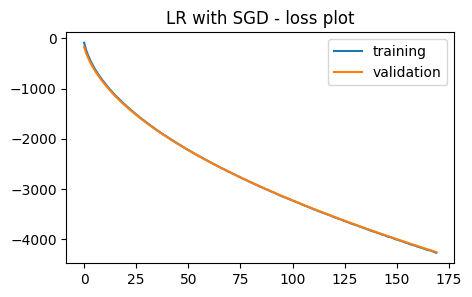

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['loss'], label='training')
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['val_loss'], label='validation')
plt.title('LR with SGD - loss plot')
plt.legend(loc='best')

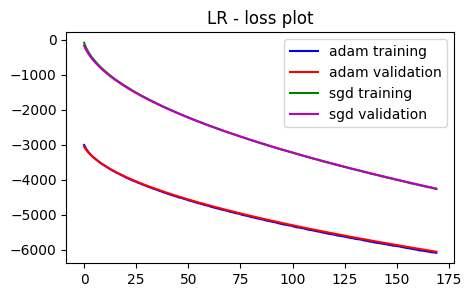

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(lr_history.epoch,lr_history.history['loss'], 'b', label='adam training')
plt.plot(lr_history.epoch,lr_history.history['val_loss'], 'r', label='adam validation')
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['loss'], 'g', label='sgd training')
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['val_loss'], 'm', label='sgd validation')
plt.title('LR - loss plot')
plt.legend(loc='best')

**Inference:**


*   Adam performance is better than the SGD performance in terms of loss and validation loss.
* The validation loss and training loss values in both models are exactly the same
*  While in both models the training and validation loss have been similar and very minimal difference is observed the range of reduction in loss value is higher in Adam when compared to SGD
* SGD redcues the loss value incrementally in smaller installments hence the curve depth is much less and almsot falt in comparison to that of Adam optimizer


# **Implement the model- MLP**

 This is a three-layer MLP model that has two dense layers with relu activation functions. The output layer has a single neuron and sigmoid non-linearity to match the groundtruth

### **MLP with Adam**

In [ ]:
# Model initialization:
mnist_mlp_model = Sequential()

mnist_mlp_model.add(Dense(units=20, input_dim=28*28))
mnist_mlp_model.add(Activation('relu'))

mnist_mlp_model.add(Dense(units=10, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
mnist_mlp_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print(mnist_mlp_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                15700     
                                                                 
 activation_1 (Activation)   (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 15910 (62.15 KB)
Trainable params: 15910 (62.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
%%time
epochs = 45
lr_scheduler = LRScheduler(initial_lr=0.001)  # utilising the custom Keras callback
mlp_history = mnist_mlp_model.fit(X_train.reshape((-1,28*28)), Y_train, epochs=epochs, batch_size=32, verbose=2, validation_split=0.2, callbacks= [lr_scheduler])

Epoch 1: Learning rate set to 0.001000
Epoch 1/45
1500/1500 - 4s - loss: 0.4476 - accuracy: 0.8747 - val_loss: 0.2604 - val_accuracy: 0.9265 - 4s/epoch - 2ms/step
Epoch 2: Learning rate set to 0.000707
Epoch 2/45
1500/1500 - 3s - loss: 0.2507 - accuracy: 0.9286 - val_loss: 0.2309 - val_accuracy: 0.9375 - 3s/epoch - 2ms/step
Epoch 3: Learning rate set to 0.000577
Epoch 3/45
1500/1500 - 3s - loss: 0.2180 - accuracy: 0.9379 - val_loss: 0.2134 - val_accuracy: 0.9418 - 3s/epoch - 2ms/step
Epoch 4: Learning rate set to 0.000500
Epoch 4/45
1500/1500 - 3s - loss: 0.1990 - accuracy: 0.9426 - val_loss: 0.2022 - val_accuracy: 0.9433 - 3s/epoch - 2ms/step
Epoch 5: Learning rate set to 0.000447
Epoch 5/45
1500/1500 - 3s - loss: 0.1862 - accuracy: 0.9461 - val_loss: 0.1947 - val_accuracy: 0.9459 - 3s/epoch - 2ms/step
Epoch 6: Learning rate set to 0.000408
Epoch 6/45
1500/1500 - 3s - loss: 0.1763 - accuracy: 0.9496 - val_loss: 0.1925 - val_accuracy: 0.9458 - 3s/epoch - 2ms/step
Epoch 7: Learning rate

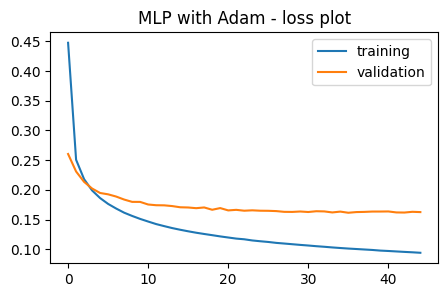

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(mlp_history.epoch,mlp_history.history['loss'], label='training')
plt.plot(mlp_history.epoch,mlp_history.history['val_loss'], label='validation')
plt.title('MLP with Adam - loss plot')
plt.legend(loc='best')

The validation loss has increased slightly in comparison to the training loss. The model requires some fine-tuning in terms of the hyperparameters and to be trained for sufficiently more epochs to overcome this problem.

In [ ]:
%%time
scores = mnist_mlp_model.evaluate(X_test.reshape((-1,28*28)), Y_test, verbose=2)
print("%s: %.2f%%" % (mnist_mlp_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 0.1479 - accuracy: 0.9562 - 524ms/epoch - 2ms/step
accuracy: 95.62%
CPU times: user 625 ms, sys: 50.7 ms, total: 675 ms
Wall time: 620 ms


### **MLP with SGD**

In [ ]:
# Model initialization:
mnist_mlp_model = Sequential()

# A bit more complex model:
mnist_mlp_model.add(Dense(units=20, input_dim=28*28))
mnist_mlp_model.add(Activation('relu'))

mnist_mlp_model.add(Dense(units=10, activation='softmax'))

optimizer = SGD(learning_rate=0.001)  # using the SGD optimizer for training
mnist_mlp_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print(mnist_mlp_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                15700     
                                                                 
 activation_2 (Activation)   (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
Total params: 15910 (62.15 KB)
Trainable params: 15910 (62.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
%%time
epochs = 45
lr_scheduler = LRScheduler(initial_lr=0.001)
mlp_history_sgd = mnist_mlp_model.fit(X_train.reshape((-1,28*28)), Y_train, epochs=epochs, batch_size=32, verbose=2, validation_split=0.2, callbacks= [lr_scheduler])

Epoch 1: Learning rate set to 0.001000
Epoch 1/45
1500/1500 - 4s - loss: 2.0049 - accuracy: 0.3543 - val_loss: 1.6337 - val_accuracy: 0.6182 - 4s/epoch - 3ms/step
Epoch 2: Learning rate set to 0.000707
Epoch 2/45
1500/1500 - 3s - loss: 1.4371 - accuracy: 0.6807 - val_loss: 1.2226 - val_accuracy: 0.7563 - 3s/epoch - 2ms/step
Epoch 3: Learning rate set to 0.000577
Epoch 3/45
1500/1500 - 3s - loss: 1.1359 - accuracy: 0.7559 - val_loss: 1.0036 - val_accuracy: 0.7939 - 3s/epoch - 2ms/step
Epoch 4: Learning rate set to 0.000500
Epoch 4/45
1500/1500 - 3s - loss: 0.9677 - accuracy: 0.7863 - val_loss: 0.8725 - val_accuracy: 0.8148 - 3s/epoch - 2ms/step
Epoch 5: Learning rate set to 0.000447
Epoch 5/45
1500/1500 - 4s - loss: 0.8621 - accuracy: 0.8043 - val_loss: 0.7861 - val_accuracy: 0.8259 - 4s/epoch - 2ms/step
Epoch 6: Learning rate set to 0.000408
Epoch 6/45
1500/1500 - 3s - loss: 0.7896 - accuracy: 0.8159 - val_loss: 0.7246 - val_accuracy: 0.8369 - 3s/epoch - 2ms/step
Epoch 7: Learning rate

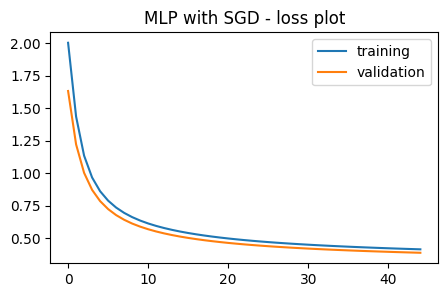

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(mlp_history_sgd.epoch,mlp_history_sgd.history['loss'], label='training')
plt.plot(mlp_history_sgd.epoch,mlp_history_sgd.history['val_loss'], label='validation')
plt.title('MLP with SGD - loss plot')
plt.legend(loc='best')

The validation loss is lower than the trainign loss and the overall loss values have subsequentl reduces as the epochs go by. During the first 10 epochs the loss values reduced drastically from 2.00 to almost 0.6

In [ ]:
%%time
scores = mnist_mlp_model.evaluate(X_test.reshape((-1,28*28)), Y_test, verbose=2)
print("%s: %.2f%%" % (mnist_mlp_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 0.3866 - accuracy: 0.8931 - 584ms/epoch - 2ms/step
accuracy: 89.31%
CPU times: user 656 ms, sys: 40.6 ms, total: 697 ms
Wall time: 671 ms


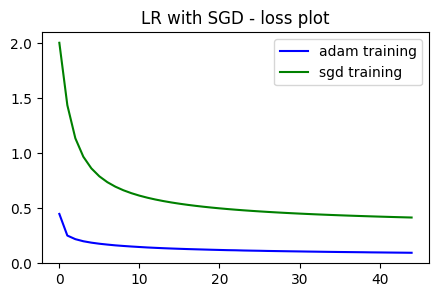

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(mlp_history.epoch,mlp_history.history['loss'], 'b', label='adam training',)
plt.plot(mlp_history_sgd.epoch,mlp_history_sgd.history['loss'], 'g', label='sgd training')
plt.title('LR with SGD - loss plot')
plt.legend(loc='best')

**Inference:**


*   Adam performance is significantly better than the SGD performance in terms of lower loss values
*  The overall loss reduction is better in SGD than Adam
*  While in both models the training and validation loss have been similar and very minimal difference is observed the range of reduction in loss value is higher in Adam when compared to SGD
*  The SGD optimizer brings down the loss value drastically between the first 10 epochs and hence the curve is deeper.
* Adam redcues the loss value incrementally in smaller installments hence the curve depth is much less and almsot falt in comparison to that of SGD optimizer


# **SGD and Adam Optimizers - Optuna**

In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import urllib
import tensorflow as tf
import optuna
from packaging import version

In [ ]:
from optuna import Trial

def objective(trial: Trial):

    # Defining the hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    # Form the layers of the model
    mnist_mlp_model = Sequential()

    # A bit more complex model:
    mnist_mlp_model.add(Dense(units=20, input_dim=28*28))
    mnist_mlp_model.add(Activation('relu'))

    mnist_mlp_model.add(Dense(units=10, activation='softmax'))

    #choosing optimiser for current trail acording to the suggest functionality
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    print(f'Optimzer: {optimizer_name}')
    if optimizer_name == "Adam":
      optimizer = Adam(learning_rate=learning_rate)
    else:
      optimizer = SGD(learning_rate = learning_rate)

    # Compile the model with the chosen optimiser and categorical_crossentropy loss function
    #               as it is a model to predict the categories
    mnist_mlp_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Defining the custom Keras callback that recursivley alters learning rate
    class CustomLRScheduler(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):

            new_lr = 1 / np.sqrt(epoch+1)
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f'Epoch {epoch + 1}: Learning Rate = {new_lr}')

    lr_scheduler = CustomLRScheduler()

    # Train the model
    history = mnist_mlp_model.fit(X_train.reshape((-1,28*28)), Y_train,
        epochs=45,
        batch_size=128,
        validation_data=(X_test.reshape((-1,28*28)), Y_test),
        validation_batch_size=128,
        callbacks=[lr_scheduler],
        verbose=0  # Adjust verbosity if needed
    )

    # Returning the value to monitored and minimised
    return history.history['val_loss'][-1]

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Get the best hyperparameters
best_params = study.best_params

trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-07 03:30:31,470] A new study created in memory with name: no-name-f5903673-d265-422f-b960-fb61940727f6


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.208514414057

[I 2023-10-07 03:31:54,631] Trial 0 finished with value: 2.312368154525757 and parameters: {'learning_rate': 3.8140249125510976e-05, 'dropout_rate': 0.29833326584688524, 'optimizer': 'Adam'}. Best is trial 0 with value: 2.312368154525757.


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.208514414057

[I 2023-10-07 03:33:05,239] Trial 1 finished with value: 2.311314344406128 and parameters: {'learning_rate': 0.001146444650748409, 'dropout_rate': 0.23622593189231836, 'optimizer': 'Adam'}. Best is trial 1 with value: 2.311314344406128.


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.208514414057

[I 2023-10-07 03:34:10,570] Trial 2 finished with value: 2.3096892833709717 and parameters: {'learning_rate': 0.0011321816890713808, 'dropout_rate': 0.3963278321429725, 'optimizer': 'Adam'}. Best is trial 2 with value: 2.3096892833709717.


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.208514414057

[I 2023-10-07 03:35:33,480] Trial 3 finished with value: 2.308659553527832 and parameters: {'learning_rate': 0.0005019034749449431, 'dropout_rate': 0.3176128744324743, 'optimizer': 'Adam'}. Best is trial 3 with value: 2.308659553527832.


Optimzer: SGD
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611
Epoch 16: Learning Rate = 0.25
Epoch 17: Learning Rate = 0.24253562503633297
Epoch 18: Learning Rate = 0.23570226039551587
Epoch 19: Learning Rate = 0.22941573387056174
Epoch 20: Learning Rate = 0.22360679774997896
Epoch 21: Learning Rate = 0.2182178902359924
Epoch 22: Learning Rate = 0.21320071635561041
Epoch 23: Learning Rate = 0.2085144140570

[I 2023-10-07 03:36:56,324] Trial 4 finished with value: 0.30075472593307495 and parameters: {'learning_rate': 0.0002812513686010162, 'dropout_rate': 0.5103532822083047, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.30075472593307495.


  Value:  0.30075472593307495
  Params: 
    learning_rate: 0.0002812513686010162
    dropout_rate: 0.5103532822083047
    optimizer: SGD


In [ ]:
best_params= study.best_params
print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'learning_rate': 0.0002812513686010162, 'dropout_rate': 0.5103532822083047, 'optimizer': 'SGD'}


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

**NOTE: As the optuna plots are not visible when adding the Colab notebook to the repo I have added them as images for your simple reference**

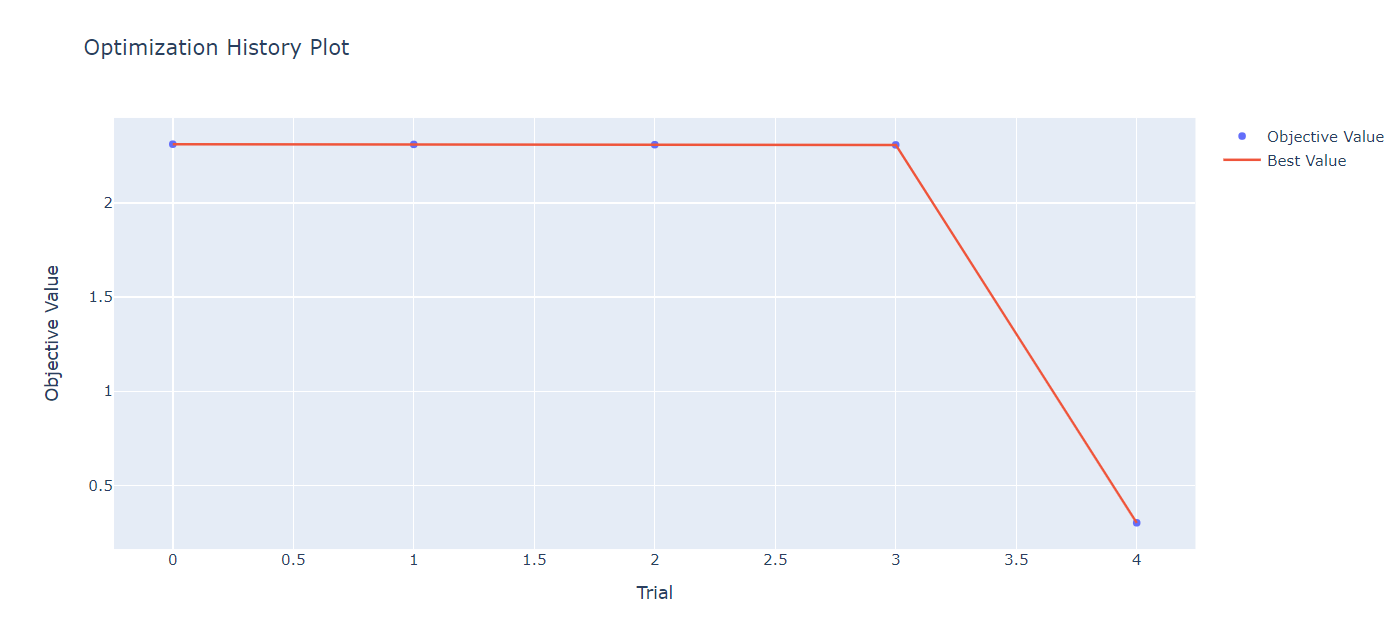

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["learning_rate", "dropout_rate"])
fig.show()

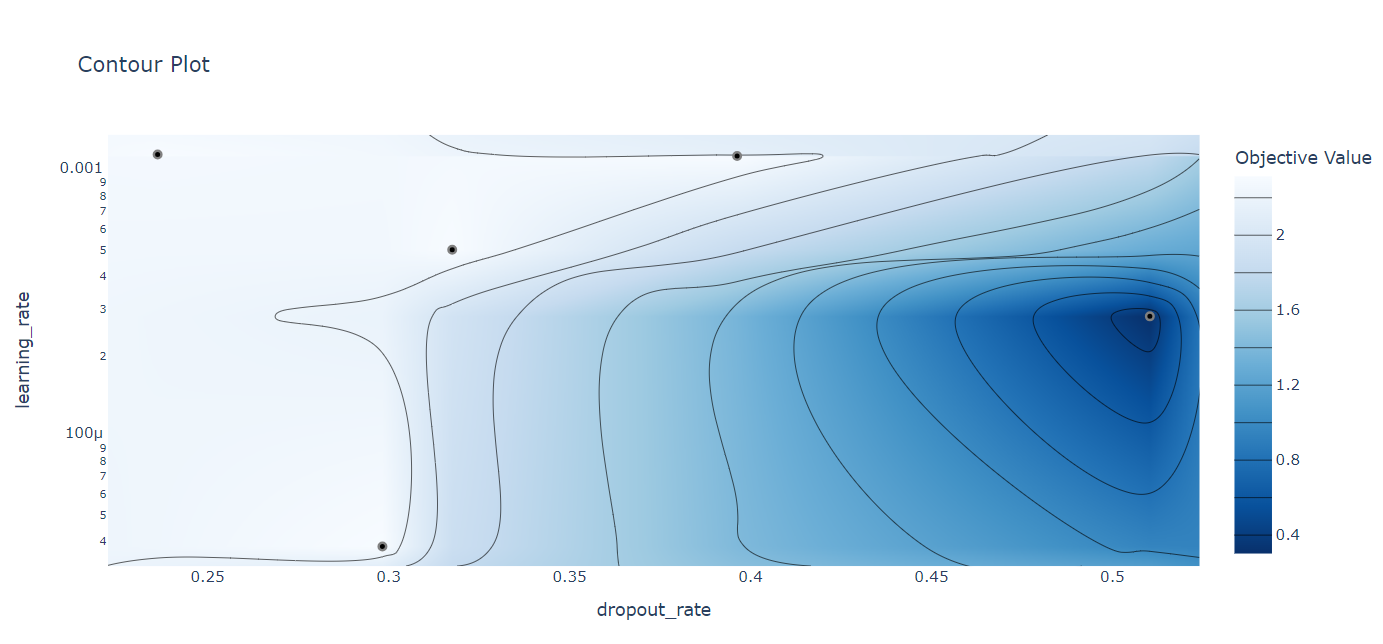

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["learning_rate", "dropout_rate", "optimizer"])
fig.show()

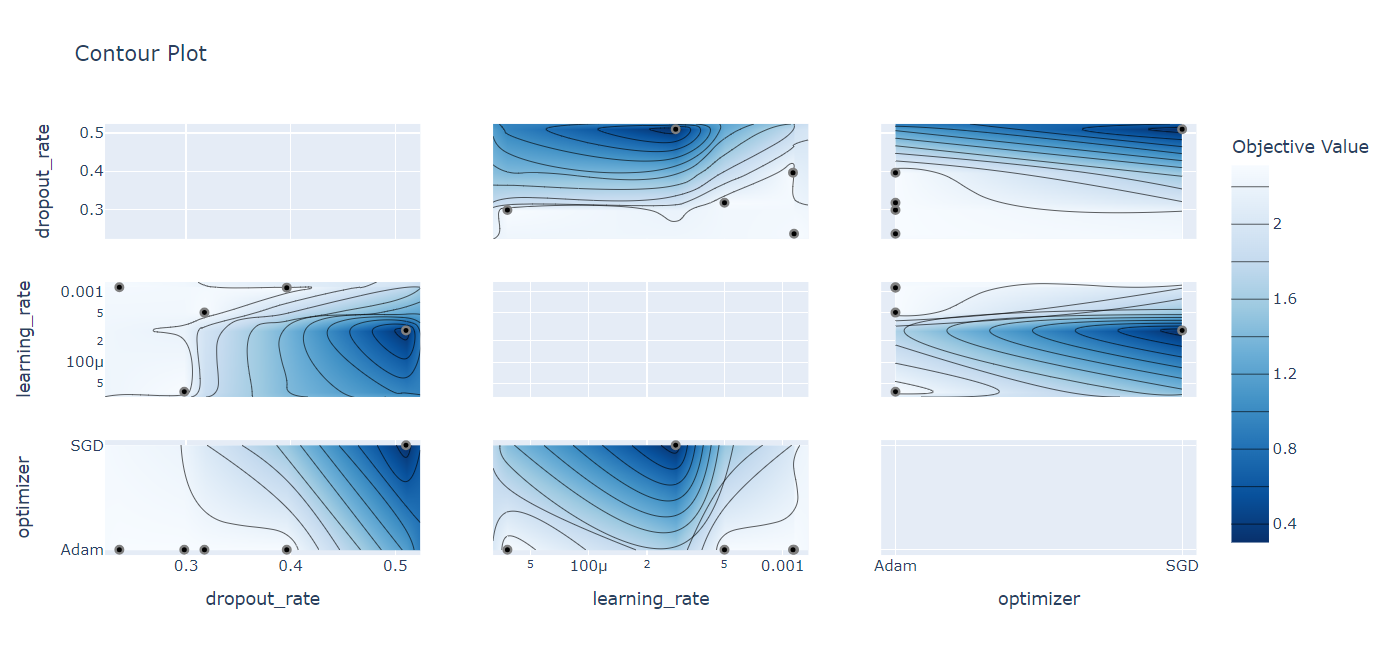

# Compare the results
After utilising Optuna to identify the hyperparameter that fits best and the optimizer that works best for the MNIST Dataset the following infferences can be made:
*   For this dataset and current training scenario, Optuna has declared SGD as the better optimiser
*  The best learning value has been deemed to be 0.00028 when using SGD optimiszer
* Although from the plot we can see that the dropout rate is significantly higher while using SGD, the value we were focusing on minimising- the validation loss has gone down while utilising SGD over Ada,
*  The model has converged towards the sGD optimzer with a lower objective value as is visible from the contour plots. Thus SGD has done a better job at converging to a minima and minimising dropout rates than Adam, contradictory to popular examples

SGD performs better on using Optuna as the hyperparamter values are designed to give it a stable dropout rate that is capable enough to reduce the validaiton loss significantly

